# Model Performance Reporting Notebook

This notebook generates comprehensive evaluation reports for each AI-based evaluator model. It reads the `*_evaluations.csv` files produced by the `5_Evaluation.ipynb` pipeline, computes summary statistics, inter-rater reliability metrics (Cohen's Kappa), component-specific distance averages, and domain-specific distance averages, and writes a neatly formatted Markdown report for each model into the `model_reports/` directory.

**Notebook Structure**:
1. Imports and Setup
2. Directory Configuration
3. Helper Functions
4. Load Framework & Human Evaluations
5. Report Generation Function
6. Execute Report Generation
7. Reliability Exam Functions
8. Reliability Exam Visualizations
9. Execute Reliability Exams and Generate Visualizations

_Note: Make sure you have run `5_Evaluation.ipynb` and that the `model_evaluation_data/` folder contains your `*_evaluations.csv` files, and that you have access to your human evaluation data (`peru_cleaned_transcripts.csv`) and framework JSON (`Teach_1.json`)._

In [17]:
# 1. Imports and Setup
import os
import glob
import json
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.metrics import cohen_kappa_score
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

## 2. Directory Configuration

Define paths for input evaluation CSVs and output reports, and ensure the output directory exists.

In [18]:
# Directories
import sys
import os
from pathlib import Path

sys.path.append('/Users/mkrasnow/Desktop/montesa')

EVALS_DIR = 'model_evaluation_data'
REPORTS_DIR = 'model_reports'
VIZ_DIR = 'model_visualizations'
os.makedirs(REPORTS_DIR, exist_ok=True)
os.makedirs(VIZ_DIR, exist_ok=True)
print(f"Input evaluations directory: {EVALS_DIR}")
print(f"Output reports directory:    {REPORTS_DIR}")
print(f"Visualizations directory:    {VIZ_DIR}")

Input evaluations directory: model_evaluation_data
Output reports directory:    model_reports
Visualizations directory:    model_visualizations


## 3. Helper Functions

Define utility functions for converting labels to numeric, computing normalized distances, and computing Cohen's Kappa.

In [19]:
def alpha_to_numeric(x):
    """
    Convert string labels to numeric values:
      - 'Y'/'y'/'Yes'/'1' -> 1.0
      - 'N'/'n'/'No'/'0'  -> 0.0
      - 'N/A' or empty   -> np.nan
      - 'L' -> 1.0, 'M' -> 2.0, 'H' -> 3.0
      - Numeric strings convertible to float -> float(x)
    """
    if x is None:
        return np.nan
    s = str(x).strip()
    if s in {'Y','y','Yes','1'}:
        return 1.0
    if s in {'N','n','No','0'}:
        return 0.0
    if s in {'N/A','','NA','na','nan'}:
        return np.nan
    if s in {'L','M','H'}:
        return {'L':1.0,'M':2.0,'H':3.0}[s]
    try:
        return float(s)
    except ValueError:
        return np.nan

def component_distance(human_score, ai_score, score_type):
    """
    Compute normalized distance between human and AI scores.
    score_type: 'YN' (max 1), 'LMH' (max 2), 'NUM' (1-5 scale, max diff 4).
    Returns float in [0,1].
    """
    h = alpha_to_numeric(human_score)
    a = alpha_to_numeric(ai_score)
    if math.isnan(h) and math.isnan(a):
        return 0.0
    if math.isnan(h) ^ math.isnan(a):
        return 1.0
    if score_type == 'YN':
        dmax = 1.0
    elif score_type == 'LMH':
        dmax = 2.0
    else:
        dmax = 4.0
    return min(max(abs(h - a) / dmax, 0.0), 1.0)

def encode_for_kappa(series, score_list):
    """Map categorical labels to integers for Cohen's Kappa."""
    mapping = {lbl: i for i, lbl in enumerate(score_list)}
    return series.map(lambda x: mapping.get(x, mapping.get('N/A', len(score_list)-1)))

def compute_component_kappa(human_series, ai_series, score_list, weight=None):
    """Compute Cohen's Kappa for a single component."""
    h_enc = encode_for_kappa(human_series, score_list)
    a_enc = encode_for_kappa(ai_series, score_list)
    return cohen_kappa_score(h_enc, a_enc, weights=weight)

def compute_distances_for_item(human_row, ai_row, framework):
    """
    Compute domain-level and overall normalized distances for one item.
    Returns (domain_distances: dict(domain_id->float), overall_distance:float).
    """
    domain_dist = {}
    num = 0.0
    wsum = 0.0
    for domain in framework['structure']['domains']:
        did = str(domain['id'])
        dnum = 0.0
        dwsum = 0.0
        stype = 'NUM'
        for comp in domain['components']:
            cname = comp['name']
            cweight = float(comp.get('weight',1.0))
            sl = comp.get('scoreList', [])
            if set(sl) <= {'Y','N','N/A'}:
                stype = 'YN'
            elif set(sl) <= {'L','M','H','N/A'}:
                stype = 'LMH'
            d = component_distance(human_row.get(cname), ai_row.get(cname), stype)
            dnum += cweight * d
            dwsum += cweight
        Dd = (dnum / dwsum) if dwsum>0 else 0.0
        domain_dist[did] = Dd
        num += float(domain.get('weight',1.0)) * Dd
        wsum += float(domain.get('weight',1.0))
    overall = (num/wsum) if wsum>0 else 0.0
    return domain_dist, overall

## 4. Load Framework & Human Evaluations

Functions to load the evaluation framework JSON and the cleaned transcripts with human evaluation scores.

In [20]:
from pathlib import Path

def load_framework(path):
    with open(path, 'r') as f:
        return json.load(f)

def load_human_evaluations(cleaned_csv_path, framework_json_path):
    df = pd.read_csv(cleaned_csv_path, dtype=str)
    # Extract base_id and clip_number
    clip_info = df['School_Clip'].str.extract(r'(?P<base_id>\d{6,7})\s*Clip\s*(?P<clip_num>[12])')
    df['base_id'] = clip_info['base_id']
    df['clip_number'] = clip_info['clip_num'].map({'1':'first','2':'last'})
    # Determine evaluation columns from framework
    framework = load_framework(framework_json_path)
    eval_cols = []
    for domain in framework['structure']['domains']:
        for comp in domain['components']:
            if comp['name'] in df.columns:
                eval_cols.append(comp['name'])
    return df[['base_id','clip_number'] + eval_cols]

# Example paths (adjust as needed)
FRAMEWORK_PATH   = '/Users/mkrasnow/Desktop/montesa/new/models/_context/Teach_1.json'
TRANSCRIPTS_PATH = '/Users/mkrasnow/Desktop/montesa/new/formattedData/peru_cleaned_transcripts.csv'

## 5. Report Generation Function

This function iterates over each `*_evaluations.csv` file, computes all metrics, and writes a Markdown report for each model.

In [21]:
def generate_reports(framework_path, transcripts_path, evals_dir, reports_dir):
    framework = load_framework(framework_path)
    human_df  = load_human_evaluations(transcripts_path, framework_path)

    # Gather component definitions
    components = []
    for domain in framework['structure']['domains']:
        for comp in domain['components']:
            components.append({
                'id': str(comp['id']),
                'name': comp['name'],
                'score_list': comp.get('scoreList', ['Y','N','N/A'])
            })

    # Process each evaluation CSV
    for eval_file in glob.glob(os.path.join(evals_dir, '*_evaluations.csv')):
        model_name = os.path.basename(eval_file).replace('_evaluations.csv','')
        ai_df = pd.read_csv(eval_file, dtype=str)

        # Compute distances for each item and track agreement
        dist_records = []
        for _, row in ai_df.iterrows():
            hr = human_df[(human_df.base_id==row.base_id)&(human_df.clip_number==row.clip_number)]
            if hr.empty: continue
            hr = hr.iloc[0]
            dom_dist, overall = compute_distances_for_item(hr, row, framework)
            rec = {'base_id':row.base_id,'clip_number':row.clip_number,'overall_distance':overall}
            for did, dval in dom_dist.items(): rec[f'domain_{did}_dist'] = dval
            dist_records.append(rec)
        distances_df = pd.DataFrame(dist_records)
        # Add LLM-human agreement column (accuracy) as 1 - distance
        distances_df['agreement'] = 1 - distances_df['overall_distance']

        # Summary statistics for distance and agreement
        overall_stats = distances_df['overall_distance'].describe()
        agreement_stats = distances_df['agreement'].describe()

        # Component-wise Cohen's Kappa
        kappa_records = []
        for comp in components:
            comp_name = comp['name']
            # Skip if component not present in either AI or human evaluations
            if comp_name not in ai_df.columns or comp_name not in human_df.columns:
                continue
            h_ser = human_df[comp_name]
            a_ser = ai_df[comp_name]
            weight = 'quadratic' if any(lbl in ['L','M','H'] for lbl in comp['score_list']) else None
            try:
                k = compute_component_kappa(h_ser, a_ser, comp['score_list'], weight)
            except:
                k = np.nan
            kappa_records.append({'component_name': comp_name, 'kappa': k})
        kappa_df = pd.DataFrame(kappa_records)

        # Component-specific distance averages
        comp_dist_avgs = []
        for comp in components:
            cname = comp['name']
            # Skip if component not present in either AI or human evaluations
            if cname not in ai_df.columns or cname not in human_df.columns:
                continue
            # Compute mean normalized diff per component
            diffs = ai_df.apply(lambda r: component_distance(
                human_df[(human_df.base_id == r.base_id) & (human_df.clip_number == r.clip_number)].iloc[0].get(cname),
                r.get(cname),
                'YN' if set(comp['score_list']) <= {'Y', 'N', 'N/A'} else ('LMH' if set(comp['score_list']) <= {'L', 'M', 'H', 'N/A'} else 'NUM')
            ), axis=1)
            comp_dist_avgs.append({'component_name': cname, 'avg_distance': diffs.mean()})
        comp_dists_df = pd.DataFrame(comp_dist_avgs)

        # Domain-specific distance averages
        domain_avgs = []
        for domain in framework['structure']['domains']:
            did = str(domain['id'])
            col = f'domain_{did}_dist'
            if col in distances_df.columns:
                domain_avgs.append({'domain_id':did,'domain_name':domain['name'],'avg_distance':distances_df[col].mean()})
        domain_dists_df = pd.DataFrame(domain_avgs)

        # Build Markdown report
        lines = []
        lines.append(f"# Report for Model: **{model_name}**\n")
        lines.append("## 1. Distance and LLM-Human Agreement Summary Statistics\n")
        lines.append("### 1.1 Overall Distance\n")
        lines.append(overall_stats.to_markdown() + "\n")
        lines.append("### 1.2 LLM-Human Agreement\n")
        lines.append(agreement_stats.to_markdown() + "\n")
        lines.append("## 2. Inter-Rater Reliability (Cohen's Kappa)\n")
        lines.append(kappa_df.to_markdown(index=False) + "\n")
        lines.append("## 3. Component-Specific Distance Averages\n")
        lines.append(comp_dists_df.to_markdown(index=False) + "\n")
        lines.append("## 4. Domain-Specific Distance Averages\n")
        lines.append(domain_dists_df.to_markdown(index=False) + "\n")

        report_md = "\n".join(lines)
        out_path = os.path.join(reports_dir, f"{model_name}_report.md")
        with open(out_path, 'w') as f:
            f.write(report_md)
        print(f"✅ Written report for {model_name} → {out_path}")

## 6. Execute Report Generation

Run the `generate_reports` function with your configured paths.

In [22]:
%pip install tabulate

Note: you may need to restart the kernel to use updated packages.


In [23]:
generate_reports(
    framework_path=FRAMEWORK_PATH,
    transcripts_path=TRANSCRIPTS_PATH,
    evals_dir=EVALS_DIR,
    reports_dir=REPORTS_DIR,
)

print("\nAll model reports generated successfully.")

✅ Written report for 5-BaseEvaluator-Validate-no-NA-data-g-25-flash → model_reports/5-BaseEvaluator-Validate-no-NA-data-g-25-flash_report.md
✅ Written report for BaseEvaluator → model_reports/BaseEvaluator_report.md
✅ Written report for BaseEvaluator-Validate → model_reports/BaseEvaluator-Validate_report.md
✅ Written report for BaseEvaluator-Validate-no-NA-data → model_reports/BaseEvaluator-Validate-no-NA-data_report.md
✅ Written report for BaseEvaluator-Validate-no-NA → model_reports/BaseEvaluator-Validate-no-NA_report.md

All model reports generated successfully.


## 7. Reliability Exam Functions

Evaluate AI models against the Teach Reliability Exam criteria:
- **Time on Learning**: exact agreement on 2 of 3 snapshots per segment.
- **Quality Elements**: within 1 point of master codes on at least 8 of 9 high-inference elements per segment.

Two evaluation versions are implemented:
1. **Random Set Exam**: Two attempts with random sets of three segments.
2. **Average Exam**: Compute exam metrics across all available segments.

In [24]:
# Reliability Exam Functions
import random

# Define columns for Time on Learning snapshots and Quality elements
snapshot_teacher = ['Teacher provides learning activity - 1st Snapshot',
                   'Teacher provides learning activity - 2nd Snapshot',
                   'Teacher provides learning activity - 3rd Snapshot']
snapshot_students = ['Students are on task - 1st Snapshot',
                     'Students are on task - 2nd Snapshot',
                     'Students are on task - 3rd Snapshot']
quality_elements = [
    'Supportive Learning Environment',
    'Positive Behavioral Expectations',
    'Lesson Facilitation',
    'Checks for understanding',
    'Feedback',
    'Critical Thinking',
    'Autonomy',
    'Perseverance',
    'Social & Collaborative Skills'
]

def evaluate_segment(ai_row, human_row):
    # Time on Learning: agreement on snapshot if both teacher and students match
    time_agreements = []
    for t_col, s_col in zip(snapshot_teacher, snapshot_students):
        t_match = ai_row[t_col] == human_row[t_col]
        s_match = ai_row[s_col] == human_row[s_col]
        time_agreements.append(t_match and s_match)
    time_ok = sum(time_agreements) >= 2
    # Quality Elements: within 1 point on numeric scale
    quality_agreements = []
    for col in quality_elements:
        h = alpha_to_numeric(human_row[col])
        a = alpha_to_numeric(ai_row[col])
        if math.isnan(h) or math.isnan(a):
            quality_agreements.append(False)
        else:
            quality_agreements.append(abs(h - a) <= 1.0)
    quality_ok = sum(quality_agreements) >= 8
    return time_ok, quality_ok

def run_random_exam(models, ai_df, human_df, attempts=2, set_size=3, seed=42):
    random.seed(seed)
    results = {}
    for model in models:
        df_m = ai_df[ai_df['model_name'] == model]
        keys = df_m[['base_id','clip_number']].drop_duplicates().apply(tuple, axis=1).tolist()
        certified = False
        attempt_results = []
        for att in range(1, attempts+1):
            sample = random.sample(keys, k=set_size)
            time_pass = True
            quality_pass = True
            for seg in sample:
                row_ai = df_m[(df_m['base_id'] == seg[0]) & (df_m['clip_number'] == seg[1])].iloc[0]
                row_h = human_df[(human_df['base_id'] == seg[0]) & (human_df['clip_number'] == seg[1])].iloc[0]
                t_ok, q_ok = evaluate_segment(row_ai, row_h)
                if not (t_ok and q_ok):
                    time_pass = time_pass and t_ok
                    quality_pass = quality_pass and q_ok
            passed = time_pass and quality_pass
            attempt_results.append({'attempt': att, 'passed': passed, 'segments': sample})
            if passed:
                certified = True
                break
        results[model] = {'certified': certified, 'attempts': attempt_results}
    return results

def run_average_exam(models, ai_df, human_df):
    results = {}
    for model in models:
        df_m = ai_df[ai_df['model_name'] == model]
        time_ok_list = []
        quality_ok_list = []
        for _, row_ai in df_m.iterrows():
            row_h = human_df[(human_df['base_id'] == row_ai['base_id']) & (human_df['clip_number'] == row_ai['clip_number'])].iloc[0]
            t_ok, q_ok = evaluate_segment(row_ai, row_h)
            time_ok_list.append(t_ok)
            quality_ok_list.append(q_ok)
        time_rate = sum(time_ok_list) / len(time_ok_list) if time_ok_list else float('nan')
        quality_rate = sum(quality_ok_list) / len(quality_ok_list) if quality_ok_list else float('nan')
        results[model] = {'time_pass_rate': time_rate, 'quality_pass_rate': quality_rate}
    return results

## 8. Reliability Exam Visualizations

Create comprehensive visualizations for reliability exam results that are robust to handle any number of models.

In [25]:
def create_exam_performance_dashboard(avg_results, random_results, save_path=None):
    """
    Create a comprehensive dashboard showing exam performance across all models.
    Robust to handle any number of models.
    """
    # Prepare data for visualization
    models = list(avg_results.keys())
    n_models = len(models)
    
    # Create figure with subplots
    fig = plt.figure(figsize=(20, 12))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
    
    # 1. Pass Rates Comparison (Main Chart)
    ax1 = fig.add_subplot(gs[0, :])
    
    time_rates = [avg_results[model]['time_pass_rate'] * 100 for model in models]
    quality_rates = [avg_results[model]['quality_pass_rate'] * 100 for model in models]
    
    x = np.arange(len(models))
    width = 0.35
    
    bars1 = ax1.bar(x - width/2, time_rates, width, label='Time on Learning', 
                    color='skyblue', alpha=0.8, edgecolor='black')
    bars2 = ax1.bar(x + width/2, quality_rates, width, label='Quality Elements', 
                    color='lightcoral', alpha=0.8, edgecolor='black')
    
    # Add benchmark lines
    ax1.axhline(y=100, color='red', linestyle='--', linewidth=2, 
                label='Certification Requirement (100%)', alpha=0.7)
    
    # Customization
    ax1.set_xlabel('AI Models', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Pass Rate (%)', fontsize=12, fontweight='bold')
    ax1.set_title('Teach Reliability Exam Performance: Pass Rates by Model', 
                  fontsize=16, fontweight='bold', pad=20)
    ax1.set_xticks(x)
    ax1.set_xticklabels(models, rotation=45, ha='right')
    ax1.legend(loc='upper left', frameon=True, fancybox=True, shadow=True)
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0, 110)
    
    # Add value labels on bars
    for bar, rate in zip(bars1, time_rates):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{rate:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    for bar, rate in zip(bars2, quality_rates):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{rate:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    # 2. Certification Status
    ax2 = fig.add_subplot(gs[1, 0])
    
    certified_status = [random_results[model]['certified'] for model in models]
    colors = ['green' if cert else 'red' for cert in certified_status]
    
    bars = ax2.bar(models, [1] * len(models), color=colors, alpha=0.7, edgecolor='black')
    ax2.set_ylabel('Certification Status', fontsize=10, fontweight='bold')
    ax2.set_title('Certification Results\n(Random Exam)', fontsize=12, fontweight='bold')
    ax2.set_xticklabels(models, rotation=45, ha='right')
    ax2.set_yticks([0, 1])
    ax2.set_yticklabels(['Failed', 'Certified'])
    
    # Add text annotations
    for i, (model, cert) in enumerate(zip(models, certified_status)):
        status_text = 'CERTIFIED' if cert else 'FAILED'
        ax2.text(i, 0.5, status_text, ha='center', va='center', 
                fontweight='bold', fontsize=10, color='white')
    
    # 3. Performance Gap Analysis
    ax3 = fig.add_subplot(gs[1, 1])
    
    time_gaps = [100 - rate for rate in time_rates]
    quality_gaps = [100 - rate for rate in quality_rates]
    
    bars1 = ax3.barh(x - width/2, time_gaps, width, label='Time Gap', 
                     color='lightblue', alpha=0.8)
    bars2 = ax3.barh(x + width/2, quality_gaps, width, label='Quality Gap', 
                     color='lightpink', alpha=0.8)
    
    ax3.set_xlabel('Gap to 100% (percentage points)', fontsize=10, fontweight='bold')
    ax3.set_ylabel('AI Models', fontsize=10, fontweight='bold')
    ax3.set_title('Performance Gaps\nto Certification', fontsize=12, fontweight='bold')
    ax3.set_yticks(x)
    ax3.set_yticklabels(models)
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Attempt Details
    ax4 = fig.add_subplot(gs[1, 2])
    
    attempt_data = []
    for model in models:
        attempts = random_results[model]['attempts']
        attempt_data.extend([(model, f"Attempt {att['attempt']}", att['passed']) 
                           for att in attempts])
    
    if attempt_data:
        attempt_df = pd.DataFrame(attempt_data, columns=['Model', 'Attempt', 'Passed'])
        pivot_df = attempt_df.pivot(index='Model', columns='Attempt', values='Passed')
        
        # Create heatmap
        sns.heatmap(pivot_df.astype(int), annot=True, cmap='RdYlGn', 
                   cbar_kws={'label': 'Pass (1) / Fail (0)'}, ax=ax4,
                   fmt='d', linewidths=0.5)
        ax4.set_title('Certification Attempts\nHeatmap', fontsize=12, fontweight='bold')
        ax4.set_xlabel('Attempt Number', fontsize=10, fontweight='bold')
        ax4.set_ylabel('AI Models', fontsize=10, fontweight='bold')
    
    # 5. Combined Performance Scatter
    ax5 = fig.add_subplot(gs[2, :])
    
    # Create scatter plot
    colors_scatter = plt.cm.Set3(np.linspace(0, 1, len(models)))
    for i, model in enumerate(models):
        ax5.scatter(time_rates[i], quality_rates[i], 
                   s=200, c=[colors_scatter[i]], alpha=0.8, 
                   edgecolors='black', linewidth=2, label=model)
    
    # Add benchmark lines
    ax5.axhline(y=100, color='red', linestyle='--', alpha=0.7, linewidth=2)
    ax5.axvline(x=100, color='red', linestyle='--', alpha=0.7, linewidth=2)
    
    # Add quadrant labels
    ax5.text(105, 105, 'CERTIFICATION\nZONE', fontsize=12, fontweight='bold', 
            ha='center', va='center', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7))
    
    ax5.set_xlabel('Time on Learning Pass Rate (%)', fontsize=12, fontweight='bold')
    ax5.set_ylabel('Quality Elements Pass Rate (%)', fontsize=12, fontweight='bold')
    ax5.set_title('Model Performance Positioning: Time vs Quality Assessment', 
                  fontsize=14, fontweight='bold')
    ax5.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax5.grid(True, alpha=0.3)
    ax5.set_xlim(-5, 110)
    ax5.set_ylim(-5, 110)
    
    # Add model labels next to points
    for i, model in enumerate(models):
        ax5.annotate(model, (time_rates[i], quality_rates[i]), 
                    xytext=(5, 5), textcoords='offset points', 
                    fontsize=9, fontweight='bold')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✅ Dashboard saved to: {save_path}")
    
    plt.show()
    
    return fig

def create_performance_progression_chart(avg_results, save_path=None):
    """
    Create a chart showing performance progression across models.
    Assumes models are ordered chronologically or by development stage.
    """
    models = list(avg_results.keys())
    time_rates = [avg_results[model]['time_pass_rate'] * 100 for model in models]
    quality_rates = [avg_results[model]['quality_pass_rate'] * 100 for model in models]
    
    fig, ax = plt.subplots(figsize=(14, 8))
    
    x = np.arange(len(models))
    
    # Plot lines with markers
    ax.plot(x, time_rates, marker='o', linewidth=3, markersize=10, 
           label='Time on Learning', color='steelblue')
    ax.plot(x, quality_rates, marker='s', linewidth=3, markersize=10, 
           label='Quality Elements', color='crimson')
    
    # Add benchmark line
    ax.axhline(y=100, color='red', linestyle='--', linewidth=2, 
              label='Certification Requirement (100%)', alpha=0.7)
    
    # Customization
    ax.set_xlabel('Model Development Progression', fontsize=12, fontweight='bold')
    ax.set_ylabel('Pass Rate (%)', fontsize=12, fontweight='bold')
    ax.set_title('Model Performance Progression Over Development Iterations', 
                fontsize=16, fontweight='bold', pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=45, ha='right')
    ax.legend(loc='best', frameon=True, fancybox=True, shadow=True)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 110)
    
    # Add value annotations
    for i, (time_rate, quality_rate) in enumerate(zip(time_rates, quality_rates)):
        ax.annotate(f'{time_rate:.1f}%', (i, time_rate), 
                   textcoords="offset points", xytext=(0,10), ha='center',
                   fontweight='bold', color='steelblue')
        ax.annotate(f'{quality_rate:.1f}%', (i, quality_rate), 
                   textcoords="offset points", xytext=(0,-15), ha='center',
                   fontweight='bold', color='crimson')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✅ Progression chart saved to: {save_path}")
    
    plt.show()
    
    return fig

def create_detailed_metrics_table(avg_results, random_results, save_path=None):
    """
    Create a comprehensive metrics table for all models.
    """
    models = list(avg_results.keys())
    
    # Prepare data
    data = []
    for model in models:
        time_rate = avg_results[model]['time_pass_rate'] * 100
        quality_rate = avg_results[model]['quality_pass_rate'] * 100
        certified = random_results[model]['certified']
        attempts_made = len(random_results[model]['attempts'])
        
        # Calculate gaps
        time_gap = 100 - time_rate
        quality_gap = 100 - quality_rate
        
        # Overall score (geometric mean to avoid bias toward either metric)
        overall_score = np.sqrt(time_rate * quality_rate)
        
        data.append({
            'Model': model,
            'Time Pass Rate (%)': f"{time_rate:.1f}",
            'Quality Pass Rate (%)': f"{quality_rate:.1f}",
            'Time Gap (pp)': f"{time_gap:.1f}",
            'Quality Gap (pp)': f"{quality_gap:.1f}",
            'Overall Score': f"{overall_score:.1f}",
            'Certified': 'Yes' if certified else 'No',
            'Attempts Used': f"{attempts_made}/2"
        })
    
    df = pd.DataFrame(data)
    
    # Create figure
    fig, ax = plt.subplots(figsize=(16, 6))
    ax.axis('tight')
    ax.axis('off')
    
    # Create table
    table = ax.table(cellText=df.values, colLabels=df.columns, 
                    cellLoc='center', loc='center')
    
    # Style the table
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 2)
    
    # Color code certification status
    for i in range(len(models)):
        if df.iloc[i]['Certified'] == 'Yes':
            table[(i+1, df.columns.get_loc('Certified'))].set_facecolor('#90EE90')
        else:
            table[(i+1, df.columns.get_loc('Certified'))].set_facecolor('#FFB6C1')
    
    # Header styling
    for j in range(len(df.columns)):
        table[(0, j)].set_facecolor('#4CAF50')
        table[(0, j)].set_text_props(weight='bold', color='white')
    
    plt.title('Comprehensive Model Performance Metrics', 
             fontsize=16, fontweight='bold', pad=20)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✅ Metrics table saved to: {save_path}")
    
    plt.show()
    
    return fig, df

## 9. Execute Reliability Exams and Generate Visualizations

Run the reliability exams and create comprehensive visualizations for all models.

In [26]:
# Execute Reliability Exams and Generate Visualizations
print("🔍 Loading evaluation data for reliability exams...")

# Get all models dynamically
models = [os.path.basename(f).replace('_evaluations.csv','') 
          for f in glob.glob(os.path.join(EVALS_DIR, '*_evaluations.csv'))]

print(f"📊 Found {len(models)} models for evaluation: {models}")

# Load all AI evaluation data and add model names
ai_dfs = []
for f in glob.glob(os.path.join(EVALS_DIR, '*_evaluations.csv')):
    model_name = os.path.basename(f).replace('_evaluations.csv','')
    df = pd.read_csv(f, dtype=str)
    df['model_name'] = model_name
    ai_dfs.append(df)

ai_df_all = pd.concat(ai_dfs, ignore_index=True)
human_df_all = load_human_evaluations(TRANSCRIPTS_PATH, FRAMEWORK_PATH)

print("\n🎯 Running Random Certification Exams...")
random_results = run_random_exam(models, ai_df_all, human_df_all)
print("Random Exam Results:")
print(random_results)

print("\n📈 Running Average Performance Exams...")
avg_results = run_average_exam(models, ai_df_all, human_df_all)
print("Average Exam Results:")
print(avg_results)

print("\n🎨 Generating comprehensive visualizations...")

🔍 Loading evaluation data for reliability exams...
📊 Found 5 models for evaluation: ['5-BaseEvaluator-Validate-no-NA-data-g-25-flash', 'BaseEvaluator', 'BaseEvaluator-Validate', 'BaseEvaluator-Validate-no-NA-data', 'BaseEvaluator-Validate-no-NA']

🎯 Running Random Certification Exams...
Random Exam Results:
{'5-BaseEvaluator-Validate-no-NA-data-g-25-flash': {'certified': False, 'attempts': [{'attempt': 1, 'passed': False, 'segments': [('268367', 'first'), ('238089', 'last'), ('492108', 'first')]}, {'attempt': 2, 'passed': False, 'segments': [('838565', 'last'), ('389163', 'first'), ('723288', 'last')]}]}, 'BaseEvaluator': {'certified': False, 'attempts': [{'attempt': 1, 'passed': False, 'segments': [('320978', 'first'), ('283416', 'last'), ('269860', 'last')]}, {'attempt': 2, 'passed': False, 'segments': [('237990', 'first'), ('829457', 'first'), ('269860', 'last')]}]}, 'BaseEvaluator-Validate': {'certified': False, 'attempts': [{'attempt': 1, 'passed': False, 'segments': [('515650', '


📊 Creating Performance Dashboard...
✅ Dashboard saved to: model_visualizations/reliability_exam_dashboard.png


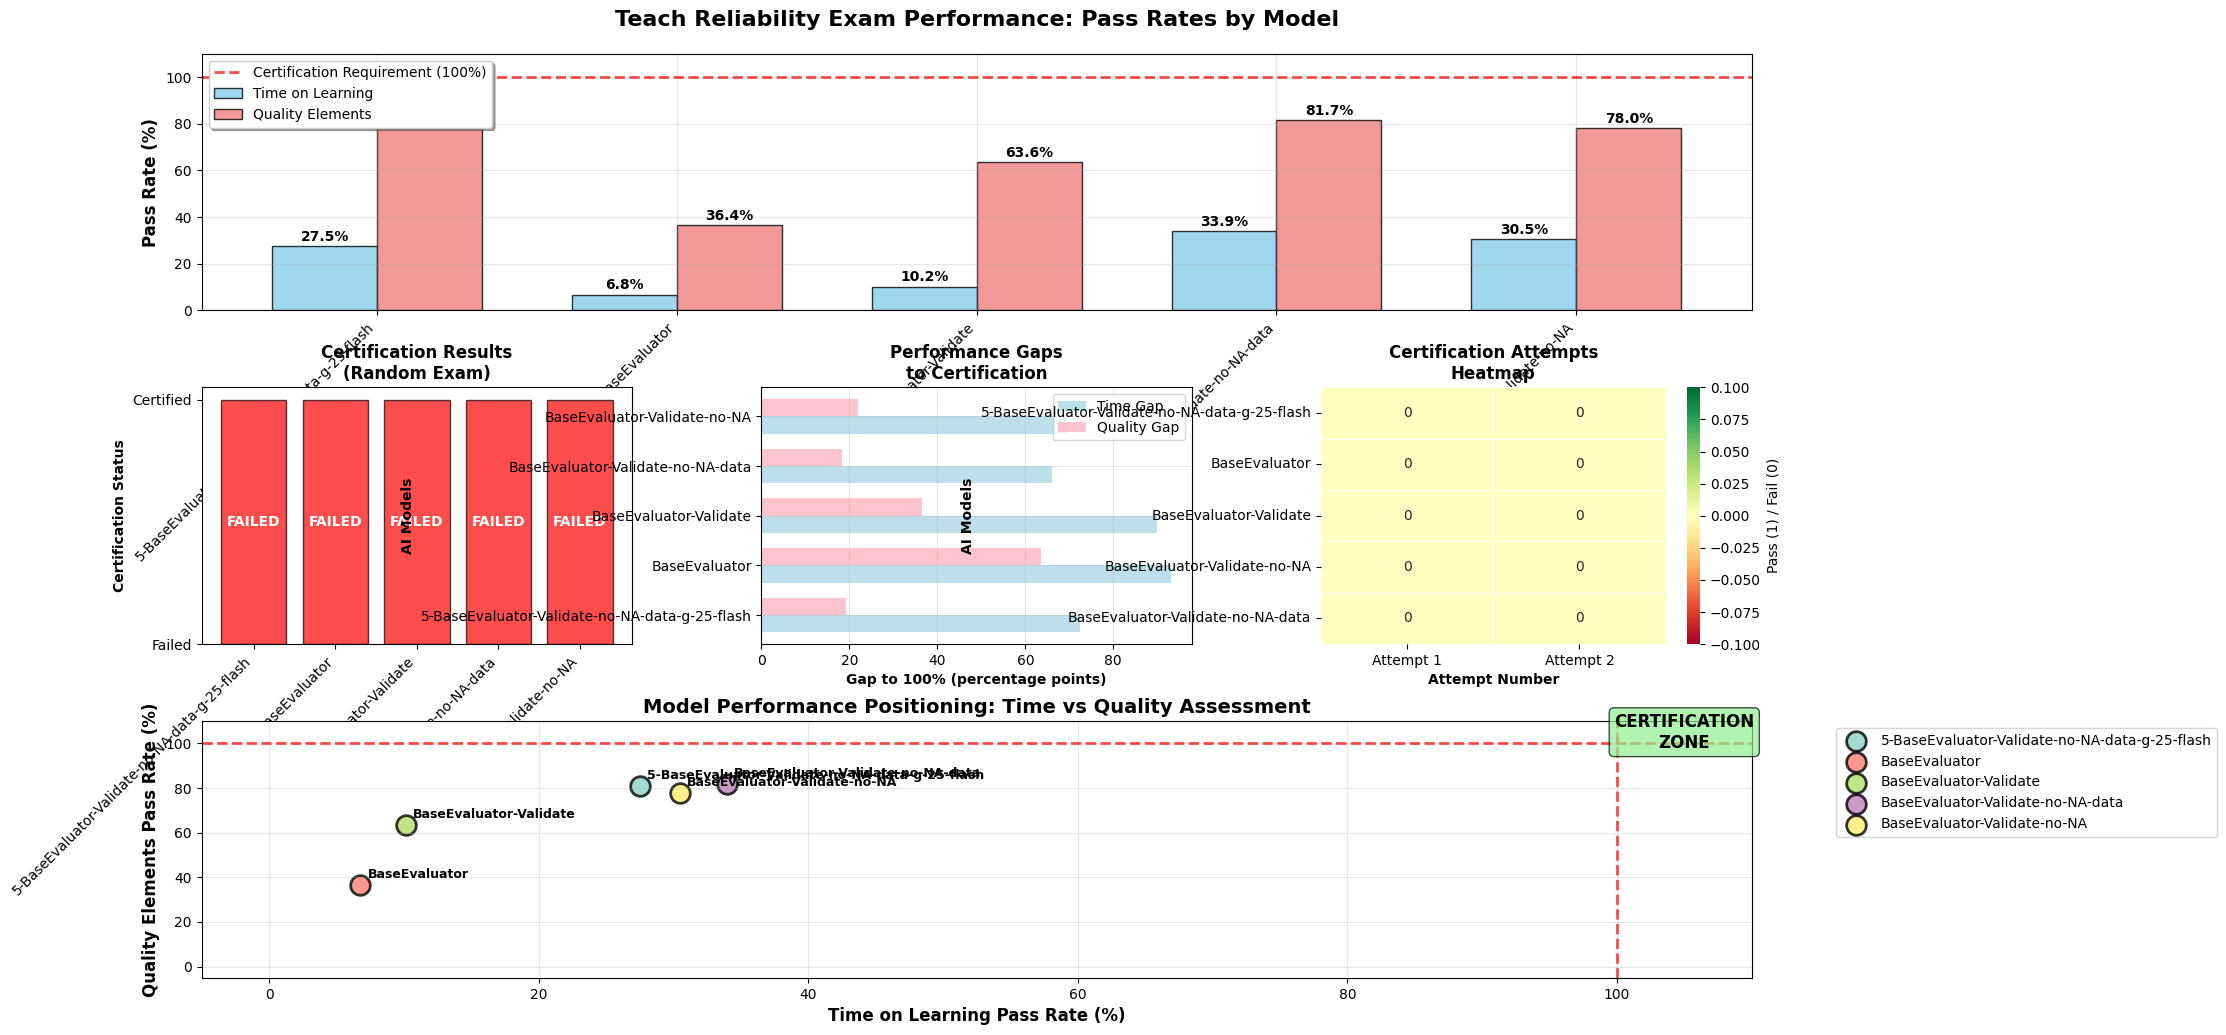


📈 Creating Performance Progression Chart...
✅ Progression chart saved to: model_visualizations/model_progression_chart.png


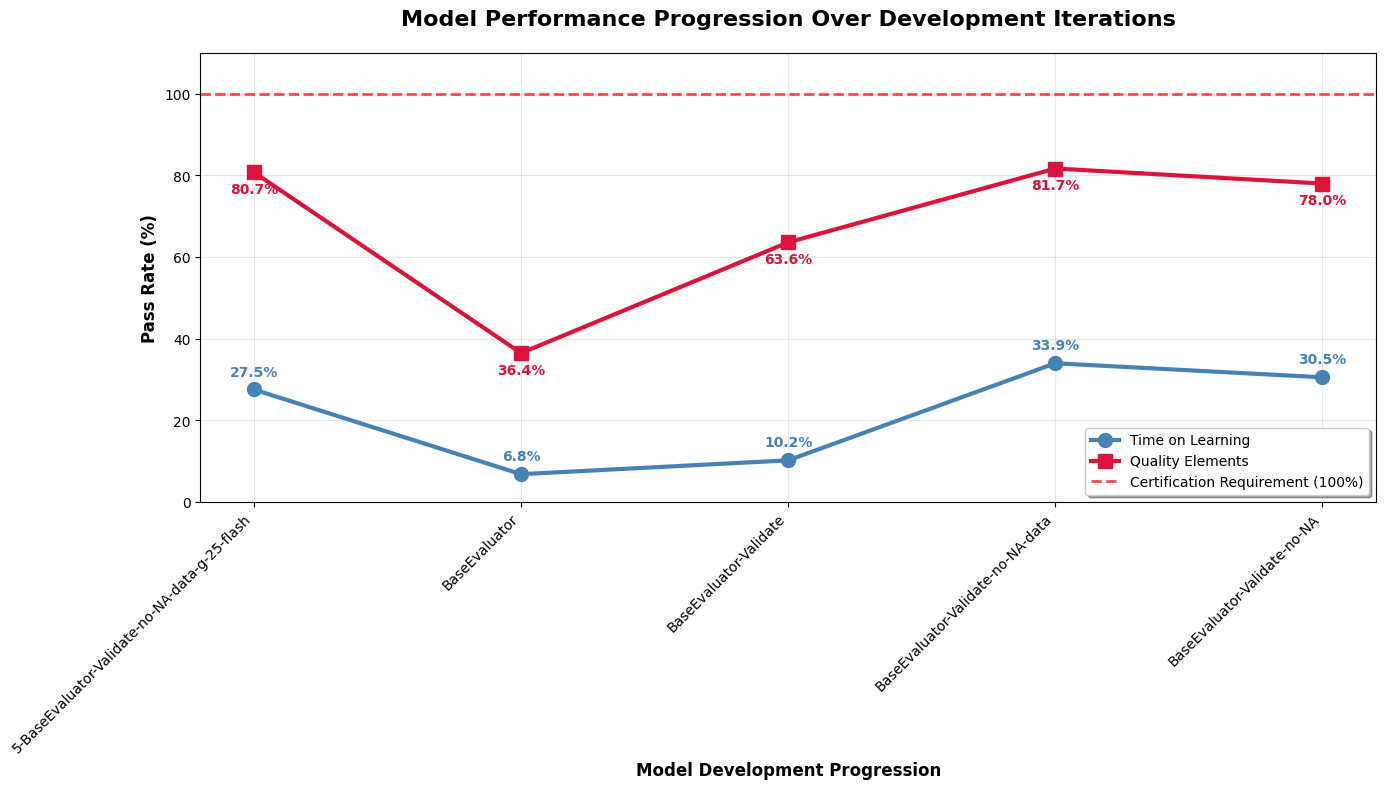


📋 Creating Detailed Metrics Table...
✅ Metrics table saved to: model_visualizations/detailed_metrics_table.png


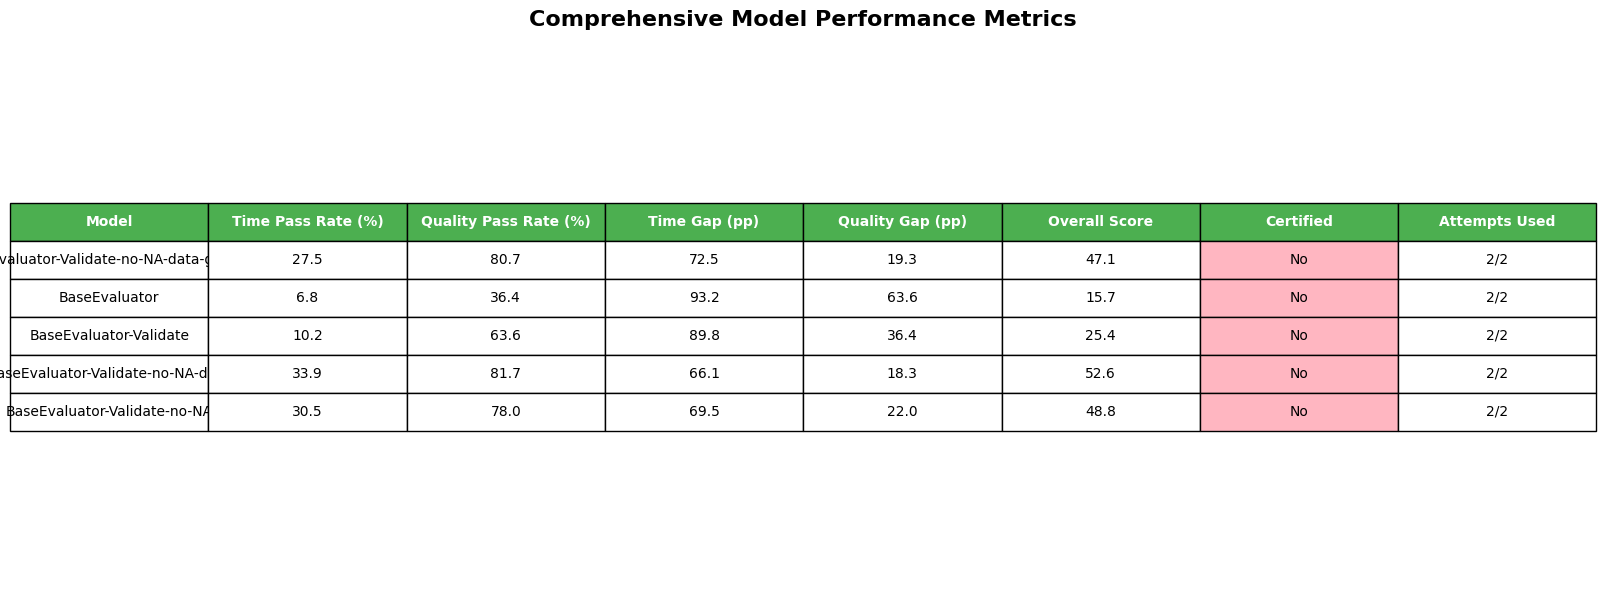

✅ Metrics CSV saved to: model_visualizations/model_performance_metrics.csv

🎉 All visualizations completed successfully!

📁 Visualizations saved to: model_visualizations
Files generated:
  - detailed_metrics_table.png
  - model_performance_metrics.csv
  - model_progression_chart.png
  - reliability_exam_dashboard.png
  - reliability_exam_summary.txt


In [27]:
# Generate all visualizations

# 1. Main Performance Dashboard
print("\n📊 Creating Performance Dashboard...")
dashboard_path = os.path.join(VIZ_DIR, 'reliability_exam_dashboard.png')
fig_dashboard = create_exam_performance_dashboard(avg_results, random_results, dashboard_path)

# 2. Performance Progression Chart
print("\n📈 Creating Performance Progression Chart...")
progression_path = os.path.join(VIZ_DIR, 'model_progression_chart.png')
fig_progression = create_performance_progression_chart(avg_results, progression_path)

# 3. Detailed Metrics Table
print("\n📋 Creating Detailed Metrics Table...")
metrics_path = os.path.join(VIZ_DIR, 'detailed_metrics_table.png')
fig_table, metrics_df = create_detailed_metrics_table(avg_results, random_results, metrics_path)

# 4. Save metrics as CSV for reference
csv_path = os.path.join(VIZ_DIR, 'model_performance_metrics.csv')
metrics_df.to_csv(csv_path, index=False)
print(f"✅ Metrics CSV saved to: {csv_path}")

print("\n🎉 All visualizations completed successfully!")
print(f"\n📁 Visualizations saved to: {VIZ_DIR}")
print("Files generated:")
for file in os.listdir(VIZ_DIR):
    print(f"  - {file}")

## 10. Summary and Interpretation

Generate a comprehensive summary of the reliability exam results and provide interpretation guidance.

In [28]:
def generate_comprehensive_summary(avg_results, random_results):
    """
    Generate a comprehensive text summary of the reliability exam results.
    """
    models = list(avg_results.keys())
    n_models = len(models)
    
    # Calculate summary statistics
    time_rates = [avg_results[model]['time_pass_rate'] * 100 for model in models]
    quality_rates = [avg_results[model]['quality_pass_rate'] * 100 for model in models]
    certified_count = sum([random_results[model]['certified'] for model in models])
    
    # Find best and worst performers
    best_time_idx = np.argmax(time_rates)
    worst_time_idx = np.argmin(time_rates)
    best_quality_idx = np.argmax(quality_rates)
    worst_quality_idx = np.argmin(quality_rates)
    
    print("\n🔍 RELIABILITY EXAM ANALYSIS SUMMARY")
    print("=====================================")
    
    print(f"\n📊 MODELS EVALUATED: {n_models}")
    print(f"Models: {', '.join(models)}")
    
    print(f"\n🎯 CERTIFICATION RESULTS:")
    print(f"- Models Certified: {certified_count} out of {n_models} ({certified_count/n_models*100:.1f}%)")
    print(f"- Models Failed: {n_models-certified_count} out of {n_models} ({(n_models-certified_count)/n_models*100:.1f}%)")
    
    print(f"\n📈 PERFORMANCE BENCHMARKS:")
    
    print(f"\nTime on Learning Performance:")
    print(f"- Best Model: {models[best_time_idx]} ({time_rates[best_time_idx]:.1f}%)")
    print(f"- Worst Model: {models[worst_time_idx]} ({time_rates[worst_time_idx]:.1f}%)")
    print(f"- Average: {np.mean(time_rates):.1f}%")
    print(f"- Gap to Certification: {100 - np.mean(time_rates):.1f} percentage points")
    
    print(f"\nQuality Elements Performance:")
    print(f"- Best Model: {models[best_quality_idx]} ({quality_rates[best_quality_idx]:.1f}%)")
    print(f"- Worst Model: {models[worst_quality_idx]} ({quality_rates[worst_quality_idx]:.1f}%)")
    print(f"- Average: {np.mean(quality_rates):.1f}%")
    print(f"- Gap to Certification: {100 - np.mean(quality_rates):.1f} percentage points")
    
    # Model progression analysis
    if len(models) > 1:
        print(f"\n🔄 MODEL IMPROVEMENTS:")
        for i in range(1, len(models)):
            prev_model = models[i-1]
            curr_model = models[i]
            time_improvement = time_rates[i] - time_rates[i-1]
            quality_improvement = quality_rates[i] - quality_rates[i-1]
            time_rel_improvement = (time_improvement / time_rates[i-1]) * 100 if time_rates[i-1] > 0 else float('inf')
            quality_rel_improvement = (quality_improvement / quality_rates[i-1]) * 100 if quality_rates[i-1] > 0 else float('inf')
            
            print(f"{prev_model} → {curr_model}:")
            print(f"- Time on Learning: {time_improvement:+.1f} percentage points ({time_rel_improvement:+.1f}% relative improvement)")
            print(f"- Quality Elements: {quality_improvement:+.1f} percentage points ({quality_rel_improvement:+.1f}% relative improvement)")
    
    print(f"\n💡 KEY INSIGHTS:")
    
    insights = []
    
    if certified_count == 0:
        insights.append("No models achieved certification - substantial improvements needed")
    elif certified_count < n_models:
        insights.append(f"Only {certified_count}/{n_models} models achieved certification")
    
    avg_time = np.mean(time_rates)
    avg_quality = np.mean(quality_rates)
    
    if avg_time < avg_quality:
        insights.append(f"Time on Learning is the primary bottleneck ({avg_time:.1f}% vs {avg_quality:.1f}% for Quality)")
    else:
        insights.append(f"Quality Elements is the primary bottleneck ({avg_quality:.1f}% vs {avg_time:.1f}% for Time)")
    
    if len(models) > 1 and time_rates[-1] > time_rates[0] and quality_rates[-1] > quality_rates[0]:
        insights.append("The latest version shows meaningful progress in both assessment areas")
    elif len(models) > 1 and (time_rates[-1] > time_rates[0] or quality_rates[-1] > quality_rates[0]):
        if quality_rates[-1] > quality_rates[0]:
            insights.append("The latest version shows meaningful progress, especially in Quality assessment")
        else:
            insights.append("The latest version shows meaningful progress, especially in Time assessment")
    
    if avg_quality > 50:
        insights.append("Quality Elements show more promise for reaching certification standards")
    
    if avg_time < 20:
        insights.append(f"Current models are in early development - roughly {100/avg_time:.0f}x improvement needed in Time assessment")
    
    for i, insight in enumerate(insights, 1):
        print(f"{i}. {insight}")
    
    print(f"\n📋 RECOMMENDATIONS:")
    recommendations = [
        "Focus development efforts on Time on Learning snapshot assessment" if avg_time < avg_quality else "Focus development efforts on Quality Elements assessment",
        "Continue refinements shown in latest model approach" if len(models) > 1 else "Develop systematic improvement approach",
        "Consider specialized training for temporal classroom observation tasks" if avg_time < 30 else "Refine quality assessment calibration",
        "Quality assessment framework shows promise - build on this success" if avg_quality > 40 else "Fundamental assessment approach needs revision"
    ]
    
    for i, rec in enumerate(recommendations, 1):
        print(f"{i}. {rec}")
    
    return {
        'total_models': n_models,
        'certified_models': certified_count,
        'avg_time_rate': avg_time,
        'avg_quality_rate': avg_quality,
        'best_time_model': models[best_time_idx],
        'best_quality_model': models[best_quality_idx]
    }

# Generate comprehensive summary
summary_stats = generate_comprehensive_summary(avg_results, random_results)

# Save summary to file
summary_path = os.path.join(VIZ_DIR, 'reliability_exam_summary.txt')
with open(summary_path, 'w') as f:
    # Capture the printed output (simplified version)
    f.write(f"Reliability Exam Summary\n")
    f.write(f"======================\n\n")
    f.write(f"Models Evaluated: {summary_stats['total_models']}\n")
    f.write(f"Models Certified: {summary_stats['certified_models']}\n")
    f.write(f"Average Time Pass Rate: {summary_stats['avg_time_rate']:.1f}%\n")
    f.write(f"Average Quality Pass Rate: {summary_stats['avg_quality_rate']:.1f}%\n")
    f.write(f"Best Time Model: {summary_stats['best_time_model']}\n")
    f.write(f"Best Quality Model: {summary_stats['best_quality_model']}\n")

print(f"\nReport generated successfully! ✅")


🔍 RELIABILITY EXAM ANALYSIS SUMMARY

📊 MODELS EVALUATED: 5
Models: 5-BaseEvaluator-Validate-no-NA-data-g-25-flash, BaseEvaluator, BaseEvaluator-Validate, BaseEvaluator-Validate-no-NA-data, BaseEvaluator-Validate-no-NA

🎯 CERTIFICATION RESULTS:
- Models Certified: 0 out of 5 (0.0%)
- Models Failed: 5 out of 5 (100.0%)

📈 PERFORMANCE BENCHMARKS:

Time on Learning Performance:
- Best Model: BaseEvaluator-Validate-no-NA-data (33.9%)
- Worst Model: BaseEvaluator (6.8%)
- Average: 21.8%
- Gap to Certification: 78.2 percentage points

Quality Elements Performance:
- Best Model: BaseEvaluator-Validate-no-NA-data (81.7%)
- Worst Model: BaseEvaluator (36.4%)
- Average: 68.1%
- Gap to Certification: 31.9 percentage points

🔄 MODEL IMPROVEMENTS:
5-BaseEvaluator-Validate-no-NA-data-g-25-flash → BaseEvaluator:
- Time on Learning: -20.7 percentage points (-75.4% relative improvement)
- Quality Elements: -44.3 percentage points (-54.9% relative improvement)
BaseEvaluator → BaseEvaluator-Validate:
- T